In [3]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
import cv2
import pandas as pd
import random

In [145]:
imgDim = 32 #image dimension
movie_length = 7 

In [146]:
#Function to generate a dimxdim image of a random shape of a size between given bounds
def shape_gen(imgDim, minimum,maximum):
    x = random_shapes((imgDim, imgDim), max_shapes=1, multichannel=False, intensity_range=(0,0),min_size = minimum, max_size=maximum)[0]
    x = (-1*x+255)/255
    return(x)

In [147]:
#Create array of start images
images_seq = [shape_gen(imgDim,10,25) for i in range(100)]
images_seq = np.array(images_seq)
images_seq = np.expand_dims(images_seq,1)
images_seq.shape

test_seq = [shape_gen(imgDim,10,25) for i in range(100)]
test_seq = np.array(test_seq)
test_seq = np.expand_dims(test_seq,1)

In [148]:
#For a given collection of start images with (n,1,k,k), with n images of dimension k by k. Trans_range is one-sided,
#so trans_range = 4 allows translations of 4 up or down, 4 left or right. same for rot_center, how much the center of 
#rotation can shift to one-side both up/down. rot_angle is maximum angle in DEGREES
def rand_trans(data, trans_range, rot_center, rot_angle): 
    n, row, col = data[:,0,:,:].shape
    Index = [random.randint(0,1) for i in range(n)] #randomly choose either translation or rotation
    
    def M_gen(i):
        if i == 0:
            hor = random.randint(-trans_range, trans_range)
            ver = random.randint(-trans_range, trans_range)
            x = np.float32([[1,0,hor],[0,1,ver]]) #create translation matrix
        else:
            center = (row/2+random.randint(-rot_center,rot_center),col/2+random.randint(-rot_center,rot_center))
            angle = random.uniform(0,rot_angle)
            x = cv2.getRotationMatrix2D(center,angle,1) #create rotation matrix
        return(x)
    
    Z = np.array([M_gen(i) for i in Index])
    
    return(Z)
    

In [149]:
M = rand_trans(images_seq, 3, 3, 45)
M2 = rand_trans(test_seq, 3, 3, 45)
M.shape

(100, 2, 3)

In [138]:
#for a given collection of start images - "data" - and their associated transformations -"transform", one for each start image-
#will generate a movie sequence of the desired length. note "data" should be np.array of shape (n,1,k,k).
def image_gen(data, transform, movie_len,imgDim):
    X = data
    for j in range(movie_len-1):
        Y = np.array([cv2.warpAffine(X[i,j],M[i],(imgDim,imgDim)) for i in range(data.shape[0])])
        Y[Y > 10] = 1
        Y = np.expand_dims(Y,1) #add the second axis, which denotes time, to concatenate the images
        X = np.concatenate((X,Y),axis=1)
    
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2]**2)
    return(X) #reshape so it's easier to work with

In [139]:
def multi_gen(test_seq, testSize, maxShapes): #now generate 
    
    #Set up first array, then just loop by concatenating.
    
    test_data = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)] #choose random number of movie sequences
    test_data = np.sum(test_data,axis= 0) #sum them together
    test_data[test_data > 1] = 1 #cap images at 1
    test_data = np.expand_dims(test_data, axis = 0) #add back the extra first axis, which indexes every movie sequence
    
    for datum in range(1,testSize):
        subset = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)]
        subset = np.sum(subset,axis=0)
        subset[subset > 1] = 1
        subset = np.expand_dims(subset, axis = 0)
        test_data = np.concatenate((test_data,subset),axis=0)
    
    return(test_data)
    

In [150]:
data = image_gen(images_seq, M, movie_length, imgDim)
test_raw = image_gen(test_seq, M2, movie_length, imgDim)
test = multi_gen(test_raw, 5, 2)

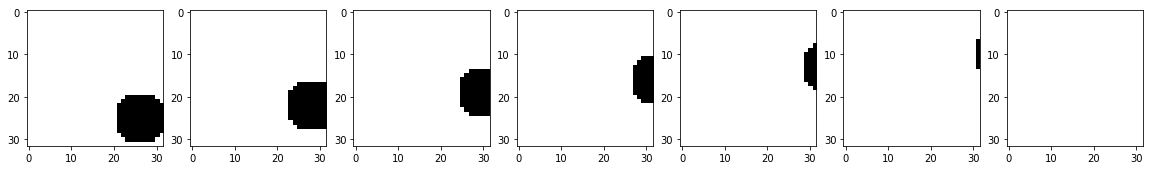

In [151]:
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(movie_length):
        fig.add_subplot(1,movie_length,i+1)
        plt.imshow(data[17,i].reshape((imgDim,imgDim)),cmap = "Greys")

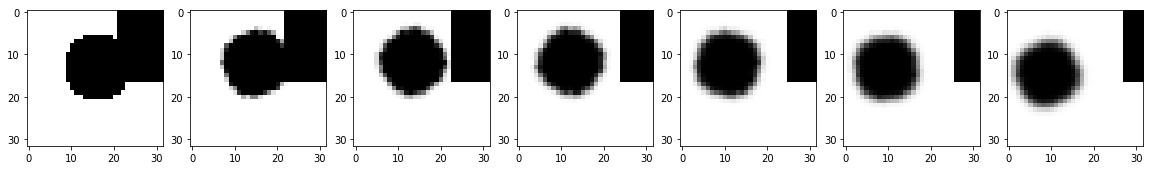

In [152]:
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(movie_length):
        fig.add_subplot(1,movie_length,i+1)
        plt.imshow(test[4,i].reshape((imgDim,imgDim)),cmap = "Greys")

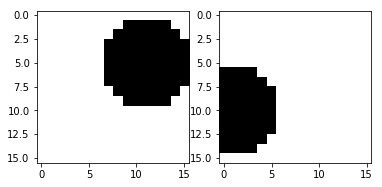

In [84]:
#Translation matrix example

test = data[1,0].reshape((imgDim,imgDim))

M = np.float32([[1,0,-10],[0,1,5]])
dst = cv2.warpAffine(test,M,(imgDim,imgDim))

fig, ax = plt.subplots(1,2)
ax[0].imshow(test, cmap= "Greys")
ax[1].imshow(dst, cmap = "Greys")

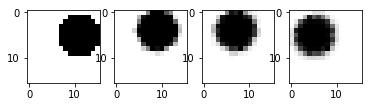

In [83]:
#Rotation matrix example

N = cv2.getRotationMatrix2D((col/2,row/2),30,1) #center, angle, scaling
dst2 = cv2.warpAffine(test,N,(col,row))
dst3 = cv2.warpAffine(dst2,N,(col,row))
dst4 = cv2.warpAffine(dst3,N,(col,row))

c = [test,dst2,dst3,dst4]

for i in range(4):
    plt.subplot(1,4, i+1)
    plt.imshow(c[i],cmap = "Greys")